<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/04_beam_selection_analog_mimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

In [66]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !ln -s /content/drive/MyDrive/ai6g_files/files_04_beam/* ./files_04_beam
    !pip install -r requirements.txt

In [67]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, \
    Flatten, MaxPooling2D, Dense, Input, Dropout, ReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from scipy.special import softmax

%matplotlib inline

In [68]:
class ModelHandler:
    def createArchitecture(self,num_classes,input_shape):
        '''
        Returns a NN model.
        numClasses: a scalar which denotes the number of classes to be predicted
        input_shape: a tuple with the dimensions of the input of the model
        '''
        dropProb=0.3
        input_lid = Input(shape = input_shape)
                    
        layer = Conv2D(10,kernel_size=(13,13),
                            activation='relu',
                            padding="SAME",
                            input_shape=input_shape)(input_lid)
        layer = Conv2D(10, (11, 11), padding="SAME", activation='relu')(layer) #original value=30 filters
        layer = Conv2D(10, (9, 9), padding="SAME", activation='relu')(layer) #original value=25 filters
        layer = MaxPooling2D(pool_size=(1, 4))(layer)
        layer = Dropout(dropProb)(layer)
        layer = Conv2D(10, (7, 7), padding="SAME", activation='relu')(layer) #original value=20 filters
        layer = MaxPooling2D(pool_size=(2, 4))(layer)
        layer = Conv2D(10, (5, 5), padding="SAME", activation='relu')(layer) #original value=15 filters
        layer = Dropout(dropProb)(layer)
        layer = Conv2D(10, (3, 3), padding="SAME", activation='relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        #layer = Conv2D(1, (1, 1), padding="SAME", activation='relu')(layer)
        layer = Flatten()(layer)
        out = Dense(num_classes,activation='softmax')(layer)
        
        architecture = Model(inputs = input_lid, outputs = out)
        
        return architecture

    def build_resblock(self, input_shape, nChannels, maxpooling=True):
        input = Input(shape=input_shape)
        x = Conv2D(nChannels, (3, 3), padding="same", activation="relu")(input)
        x = Conv2D(nChannels, (3, 3), padding="same", activation=None)(x)
        x = input + x
        x = ReLU()(x)
        if maxpooling:
            x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
        return Model(inputs=input, outputs=x)


In [69]:
###############################################################################
# Support functions
###############################################################################

# For description about top-k, including the explanation on how they treat ties (which can be misleading
# if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)
# https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k


def top_10_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)


def top_30_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=30)


def top_50_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=50)


def top_100_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=100)


def sub2ind(array_shape, rows, cols):
    ind = rows * array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0] * array_shape[1]] = -1
    return ind


def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0] * array_shape[1]] = -1
    rows = ind.astype("int") / array_shape[1]
    cols = ind % array_shape[1]
    return (rows, cols)


def beamsLogScale(y, thresholdBelowMax):
    y_shape = y.shape

    for i in range(0, y_shape[0]):
        thisOutputs = y[i, :]
        logOut = 20 * np.log10(thisOutputs + 1e-30)
        minValue = np.amax(logOut) - thresholdBelowMax
        zeroedValueIndices = logOut < minValue
        thisOutputs[zeroedValueIndices] = 0
        thisOutputs = thisOutputs / sum(thisOutputs)
        y[i, :] = thisOutputs

    return y

#converts the combined channel gains into the label vector y
#to be used for training the model. For instance, if a softmax
#activation is used in the DNN output, then make y sum up to 1.
def prepare_output_labels(original_gains):  
    method = 1 #for using DNN output with softmax activation    
    if method == 1:
        thresholdBelowMax = 60 #threshold in dB for zeroing gains in log domain
        y = log_normalize_channel_gain(original_gains,thresholdBelowMax)
    return y

#converts to log scale and make zero the values below the specified threshold
def log_normalize_channel_gain(y,thresholdBelowMax):
    num_gains = len(y)
    #print('AK',num_gains)
    for i in range(0,y.shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            #normalize to sum up to 1, and enable using softmax activation
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs        
    return y

#instead of representing the pair of beam indices with two integers, use only one integer.
#for instance, if yMatrix has a shape of (11194, 8, 32), where 8 is the number of Rx antennas
#and 32 the number of Tx antennas, then y_output has the shape (11194, 256) because 256=8*32.
#this way, a single index will indicate the pair of indices
def convert_pair_to_index(yMatrix):
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    return y, num_classes


def getBeamOutput(output_file):

    print("Reading dataset...", output_file)
    output_cache_file = np.load(output_file)
    yMatrix = output_cache_file["output_classification"]

    num_classes = 256

    pairs = [[i, j] for i in range(8) for j in range(32)]
    yMatrix = yMatrix.tolist()
    indexes = [pairs.index(yMatrix[item]) for item in range(len(yMatrix))]

    y = to_categorical(indexes, num_classes)

    return y, num_classes

In [70]:
###############################################################################
# Data configuration
###############################################################################
#tf.device("/device:GPU:0") #commented out because we will run on CPU

num_epochs = 1 #only one epoch because training takes long
batch_size = 32
tgtRec = 3
seed = 0

np.random.seed(seed)

lidar_train_input_file = "./files_04_beam/lidar_input/lidar_input.npz"
lidar_train_cache_file = np.load(lidar_train_input_file)
X_lidar = lidar_train_cache_file["input"]
X_lidar_train, X_lidar_validation = train_test_split(
    X_lidar, test_size=0.2, random_state=seed, shuffle=True
)
print("Reading dataset... ", lidar_train_input_file)
lidar_train_input_shape = X_lidar_train.shape

Reading dataset...  ./files_04_beam/lidar_input/lidar_input.npz


In [71]:
###############################################################################
# Output configuration
output_file = "./files_04_beam/beam_output/beams_output.npz"

print("Reading dataset...", output_file)
output_cache_file = np.load(output_file)
yMatrix = output_cache_file['output_classification']
y_output, num_classes = convert_pair_to_index(yMatrix)
y = prepare_output_labels(y_output)

(
    X_lidar_train,
    X_lidar_validation,
    y_train,
    y_validation,
) = train_test_split(
    X_lidar, y_output, test_size=0.2, random_state=seed, shuffle=True
)

Reading dataset... ./files_04_beam/beam_output/beams_output.npz


In [72]:
##############################################################################
# Model configuration
##############################################################################

modelHand = ModelHandler()
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam",
)

model = modelHand.createArchitecture(
    num_classes,
    [
        lidar_train_input_shape[1],
        lidar_train_input_shape[2],
        lidar_train_input_shape[3],
    ],
)

model.compile(
    loss=categorical_crossentropy,
    optimizer=opt,
    metrics=[
        metrics.categorical_accuracy,
        metrics.top_k_categorical_accuracy,
        top_10_accuracy,
        top_30_accuracy,
        top_50_accuracy,
        top_100_accuracy,
    ],
)
model.summary()
hist = model.fit(
    X_lidar_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_lidar_validation, y_validation),
)

# with open("history.txt", "w") as f:
#     f.write(str(hist.history))


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 200, 10)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 20, 200, 10)       16910     
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 200, 10)       12110     
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 200, 10)       8110      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 50, 10)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 20, 50, 10)        0         
                                                           

In [73]:
"""##Baselines cores"""

beam_weights = {}
for i in range(y_train.shape[1]):
    beam_weights[i] = 0

for i in range(y_train.shape[0]):
    scene_array = y_train[i, :]
    beam_weights[np.argmax(scene_array)] += 1

ocurrence = np.zeros((1, y_validation.shape[1]))
oc_factor = sum(beam_weights.values())
for b_index in beam_weights.keys():
    ocurrence[0, b_index] = beam_weights[b_index] / oc_factor

# ocurrence
ocurrence_input = np.repeat(ocurrence, y_validation.shape[0], axis=0)
ocurrence_output = softmax(ocurrence_input, axis=1)
# rand
rand_input = np.random.rand(X_lidar_validation.shape[0], 256)
rand_output = softmax(rand_input, axis=1)


Text(0.5, 1.0, 'LIDAR data')

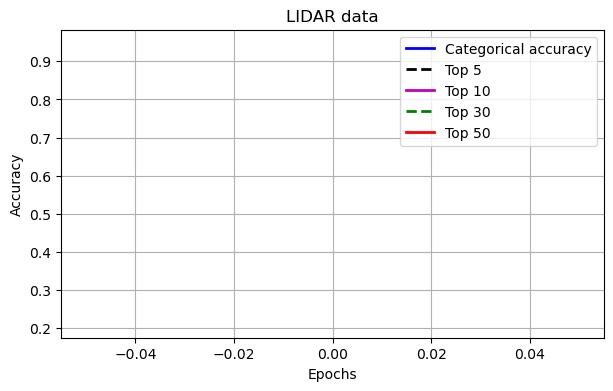

In [74]:
"""#Accuracy / epochs"""

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(
    hist.history["categorical_accuracy"], "b", label="Categorical accuracy", linewidth=2
)
ax.plot(hist.history["top_k_categorical_accuracy"], "k--", label="Top 5", linewidth=2)
ax.plot(hist.history["top_10_accuracy"], "m", label="Top 10", linewidth=2)
ax.plot(hist.history["top_30_accuracy"], "g--", label="Top 30", linewidth=2)
ax.plot(hist.history["top_50_accuracy"], "r", label="Top 50", linewidth=2)
ax.set(xlabel="Epochs", ylabel="Accuracy")
ax.grid()
plt.legend()
plt.title('LIDAR data')

In [75]:
ocurrence_output = np.float32(ocurrence_output)

In [76]:
rand_output = np.float32(rand_output)

In [77]:
"""##Creating Baselines"""

predict_top_k = {}
ocurrence_top_k = {}
random_top_k = {}
y_predict = model.predict(X_lidar_validation)
for i in range(1, 51):
    predict_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, y_predict, k=i))
        / y_predict.shape[0]
    )
    ocurrence_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, ocurrence_output, k=i))
        / y_predict.shape[0]
    )
    random_top_k[f"top_{i}"] = (
        np.sum(top_k_categorical_accuracy(y_validation, rand_output, k=i))
        / y_predict.shape[0]
    )

70/70 [==============================] - 1s 9ms/step


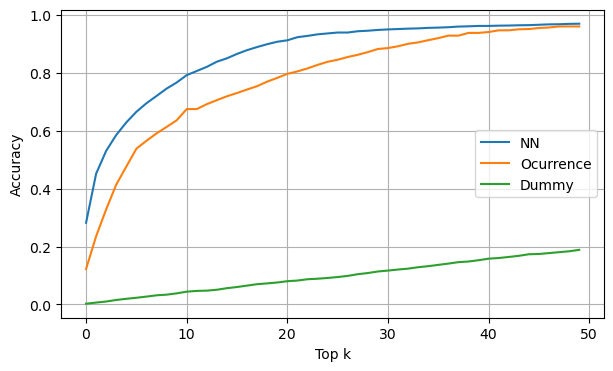

In [78]:
"""## TOP 10 acurracy"""
if False: #we disable when there is a small number of data to create the histograms
    plt.figure(figsize=(7, 4))
    plt.hist(predict_top_k["top_10"])
    plt.hist(ocurrence_top_k["top_10"])
    plt.hist(random_top_k["top_10"])

plt.figure(figsize=(7, 4))
plt.xlabel("Top k")
plt.ylabel("Accuracy")
plt.plot(list(predict_top_k.values()), label="NN")
plt.plot(list(ocurrence_top_k.values()), label="Ocurrence")
plt.plot(list(random_top_k.values()), label="Dummy")
plt.grid()
plt.legend()

## Authors

- [João Borges - LASSE/UFPA](https://github.com/joaotavares43)
- [Luan Gonçalves - LASSE/UFPA](https://github.com/LuanAGoncalves)
- [Ailton Oliveira - LASSE/UFPA](https://github.com/AiltonOliveir)
- [Daniel Takashi - LASSE/UFPA](https://github.com/orgs/lasseufpa/people/TakashiDan0)